# Schedule TPC-DS 1 Descriptor

This notebook contains work pertatining to pattern learning / identification for a database workload schedule. It contains descriptors of the available data through plot visualizations, so as to better understand which resource play a part into reflecting underlying workloads.

## Data Preprocessing

### Module Installation and Importing Libraries

In [4]:
# Module Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Configuration Cell

Tweak parametric changes from this cell to influence outcome of experiment. 
NB: This experiment demonstrates at time  step = 1 (1 minute in advance). Further down in experiment, other timestep results are also featured and evaluated.

In [5]:
tpcds='TPCDS1'

### Read data from file into Pandas Dataframes

In [6]:
# Root path
#root_dir = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds
root_dir = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds

# Open Data
rep_hist_snapshot_path = root_dir + '/rep_hist_snapshot.csv'
rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path)

def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list

rep_hist_snapshot_headers = prettify_header(rep_hist_snapshot_df.columns.values)

# Replace original headers with a prettified version of the same column list
rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path, names=rep_hist_snapshot_headers)

rep_hist_snapshot_df.drop(rep_hist_snapshot_df.index[0],inplace=True)

print(rep_hist_snapshot_df.head())

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (0,1,2,4,5,7,8,9,10,13,14,15,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,77,78,79,81,86,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


  SNAP_ID        DBID INSTANCE_NUMBER         SQL_ID PLAN_HASH_VALUE  \
1   43414  2634225673               1  03ggjrmy0wa1w      3995561526   
2   43414  2634225673               1  06dymzb481vnd      3652725360   
3   43414  2634225673               1  0aq14dznn91rg       389704395   
4   43414  2634225673               1  0f60bzgt9127c      4070789595   
5   43414  2634225673               1  0ga8vk4nftz45      3344603960   

  OPTIMIZER_COST OPTIMIZER_MODE OPTIMIZER_ENV_HASH_VALUE SHARABLE_MEM  \
1            877       ALL_ROWS                258087403        78554   
2          21525       ALL_ROWS               3207304630       518602   
3            836       ALL_ROWS                258087403        78385   
4            312       ALL_ROWS                258087403       105537   
5            300       ALL_ROWS                258087403       128838   

  LOADED_VERSIONS      ...       \
1               3      ...        
2               5      ...        
3               3      

# Dataset Description

All data sources are retrieved from Oracle defined tables/views. These sources have been specifically chosen because they accurately portray a database system under load, across a period of time. Such data sources were polled at regular intervals (60 seconds), and recorded into intermediatery tables for future data mining potential. Each statistic set corresponds to a 'SNAP_ID', which quantifies a particular resource usage at a point in time. 'SNAP_ID' delta equates to 60 seconds. In addition, relavent SQL access plans taken during the workloads execution were also captured.

Statistical calculations:
* Column Names
* Dataframe Row Counts
* Mean (were applicable)
* Standard Dev (were applicable)
* Quartile Percentile
* Min / Max

In [7]:
print('-----------------------------------------------------------')
print('Dataframe Row Count: HIST_SNAPSHOT - ' + str(len(rep_hist_snapshot_df)))
print('-----------------------------------------------------------\n')

print('HIST_SNAPSHOT:')
print(rep_hist_snapshot_df.describe())

-----------------------------------------------------------
Dataframe Row Count: HIST_SNAPSHOT - 1589392
-----------------------------------------------------------

HIST_SNAPSHOT:
        SNAP_ID        DBID  INSTANCE_NUMBER         SQL_ID  PLAN_HASH_VALUE  \
count   1589392     1589392          1589392        1589392          1589392   
unique    19832           2                2           4104             2238   
top       49747  2634225673                1  d7w1dugmzb9n9                0   
freq        120     1581201          1581201          30660           243207   

        OPTIMIZER_COST OPTIMIZER_MODE  OPTIMIZER_ENV_HASH_VALUE  SHARABLE_MEM  \
count        1469968.0        1479466              1.479466e+06       1589392   
unique          3381.0              4              9.100000e+01         69235   
top                1.0       ALL_ROWS              3.207305e+09         15310   
freq          232782.0        1181435              8.130940e+05         11306   

        LOAD

# Dataset Extraction

The above datasets were extracted from the following user defined tables:
* REP_HIST_SNAPSHOT

Each table corresponds to an Oracle defined table, whose sole function is to offload data from Oracle defined tables (which tend to have a retention period) into a user defined table. Table REP_HIST_SNAPSHOT, REP_HIST_SYSMETRIC_SUMMARY and REP_HIST_SYSSTAT can be joined through the 'SNAP_ID' column. Table REP_VSQL_PLAN can be joined to REP_HIST_SNAPSHOT through the 'SQL_ID' column.

For table REP_HIST_SNAPSHOT, the Oracle history table DBA_HIST_SNAPSHOT (https://docs.oracle.com/cd/B19306_01/server.102/b14237/statviews_3177.htm#REFRN23442) was joined with DBA_HIST_SQLSTAT (https://docs.oracle.com/cd/B13789_01/server.101/b10755/statviews_2158.htm). This gives us a snapshot with information regarding oracle's workload repository. The specific query used can be found further below.

``` sql
/*REP_HIST_SNAPSHOT*/
select dhsql.*,
       dhsnap.startup_time,
       dhsnap.begin_interval_time,
       dhsnap.end_interval_time,
       dhsnap.flush_elapsed,
       dhsnap.snap_level,
       dhsnap.error_count,
       dhsnap.snap_flag,
       dhsnap.snap_timezone,
       dhsnap.con_id
from dba_hist_sqlstat dhsql,
     dba_hist_snapshot dhsnap
where dhsql.snap_id = dhsnap.snap_id
and dhsql.dbid = dhsnap.dbid
and dhsql.instance_number = dhsnap.instance_number
and dhsnap.snap_id between '544' and '545';
```

# Data Visualization

The following section visualizes each dataset through a number of pictorial graphs, so as to better visualize the underlying load distribution.

## Table DBA_HIST_SNAPSHOT 

Plotting database snapshot resources over time

``` sql
/*REP_HIST_SNAPSHOT*/
select dhsql.*,
       dhsnap.startup_time,
       dhsnap.begin_interval_time,
       dhsnap.end_interval_time,
       dhsnap.flush_elapsed,
       dhsnap.snap_level,
       dhsnap.error_count,
       dhsnap.snap_flag,
       dhsnap.snap_timezone,
       dhsnap.con_id
from dba_hist_sqlstat dhsql,
     dba_hist_snapshot dhsnap
where dhsql.snap_id = dhsnap.snap_id
and dhsql.dbid = dhsnap.dbid
and dhsql.instance_number = dhsnap.instance_number
and dhsnap.snap_id between '544' and '545';
```

In [8]:
def plot_snapshot_distribution(table=None, column=None, tpc_type=None):
    """
    Plots line graph.
    """
    if column is None or tpc_type is None:
        raise ValueError('Parameters were declared incorrectly!')
    tpc_type = tpc_type.upper()
    table=table.lower()
    
    if table == 'rep_hist_snapshot':
        df = rep_hist_snapshot_df
    elif table == 'rep_hist_sysmetric_summary':
        df = rep_hist_sysmetric_summary_df
    elif table == 'rep_hist_sysstat':
        df = rep_hist_sysstat_df
    else:
        raise ValueError('Table Name not supported!')
    
    # Convert to float
    df['SNAP_ID'] = df['SNAP_ID'].astype(float)
    df[column]=df[column].astype(float)
    start_snap, end_snap = int(df['SNAP_ID'].min()), int(df['SNAP_ID'].max())
    
    # Sort by order of execute time
    df = df.sort_values(by=['SNAP_ID'])
    
    # Group by SNAP_ID
    df = df.groupby(['SNAP_ID'])[column].sum()
    
    fig, ax = plt.subplots()
    df.plot(kind='line', x='SNAP_ID', y=column, ax=ax)
    plt.ylabel(column)
    plt.xlabel('SNAP ID')
    plt.title(tpc_type + ' ' + str(column) + " between " + str(start_snap) + " - " + str(end_snap))
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.show()

def plot_snapshot_ratios(table=None, column=None, tpc_type=None):
    """
    Plots Pie Chart
    """
    if column is None or tpc_type is None:
        raise ValueError('Parameters were declared incorrectly!')
    tpc_type = tpc_type.upper()
    table=table.lower()
    
    if table == 'rep_hist_snapshot':
        df = rep_hist_snapshot_df
    elif table == 'rep_hist_sysmetric_summary':
        df = rep_hist_sysmetric_summary_df
    elif table == 'rep_hist_sysstat':
        df = rep_hist_sysstat_df
    elif table == 'rep_vsql_plan':
        df = rep_vsql_plan_df
    else:
        raise ValueError('Table Name not supported!')
    
    df = df.groupby([column])[column].count()
    
    # Sort by operation counts
    series = pd.Series(df.values, index=df.index, name='series')
    series.plot.pie(figsize=(6, 6))
    #plt.xticks([])
    plt.ylabel(column)
    plt.title(tpc_type + ' ' + str(column) + ' Ratio')
    plt.rcParams['figure.figsize'] = [40, 30]
    plt.legend(bbox_to_anchor=(0.95,0.95))
    plt.show()

### Optimizer Cost Distribution

Summed cost attributed by the optimizer for a particular snapshot (summed on all recorded child cursors for a particular snap_id). These metrics are retrieved from table REP_HIST_SNAPSHOT (DBA_HIST_SNAPSHOT).

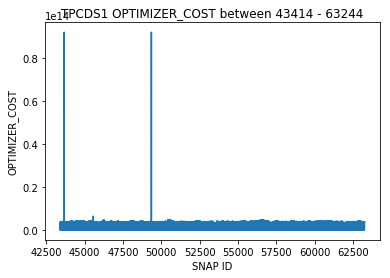

In [9]:
plot_snapshot_distribution(table="rep_hist_snapshot", column="OPTIMIZER_COST", tpc_type=tpcds)

### Optimizer Mode

Mode under which the SQL statement is executed

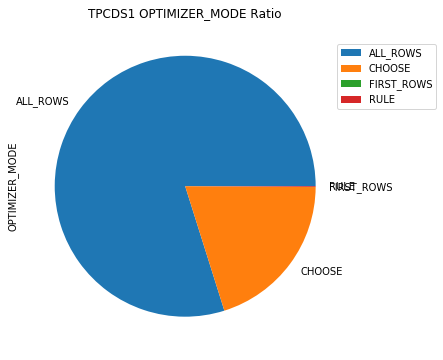

In [10]:
plot_snapshot_ratios(table="rep_hist_snapshot", column="OPTIMIZER_MODE", tpc_type=tpcds)

### Sharable Memory

Summed amount of shared memory used by the child cursors (in bytes)

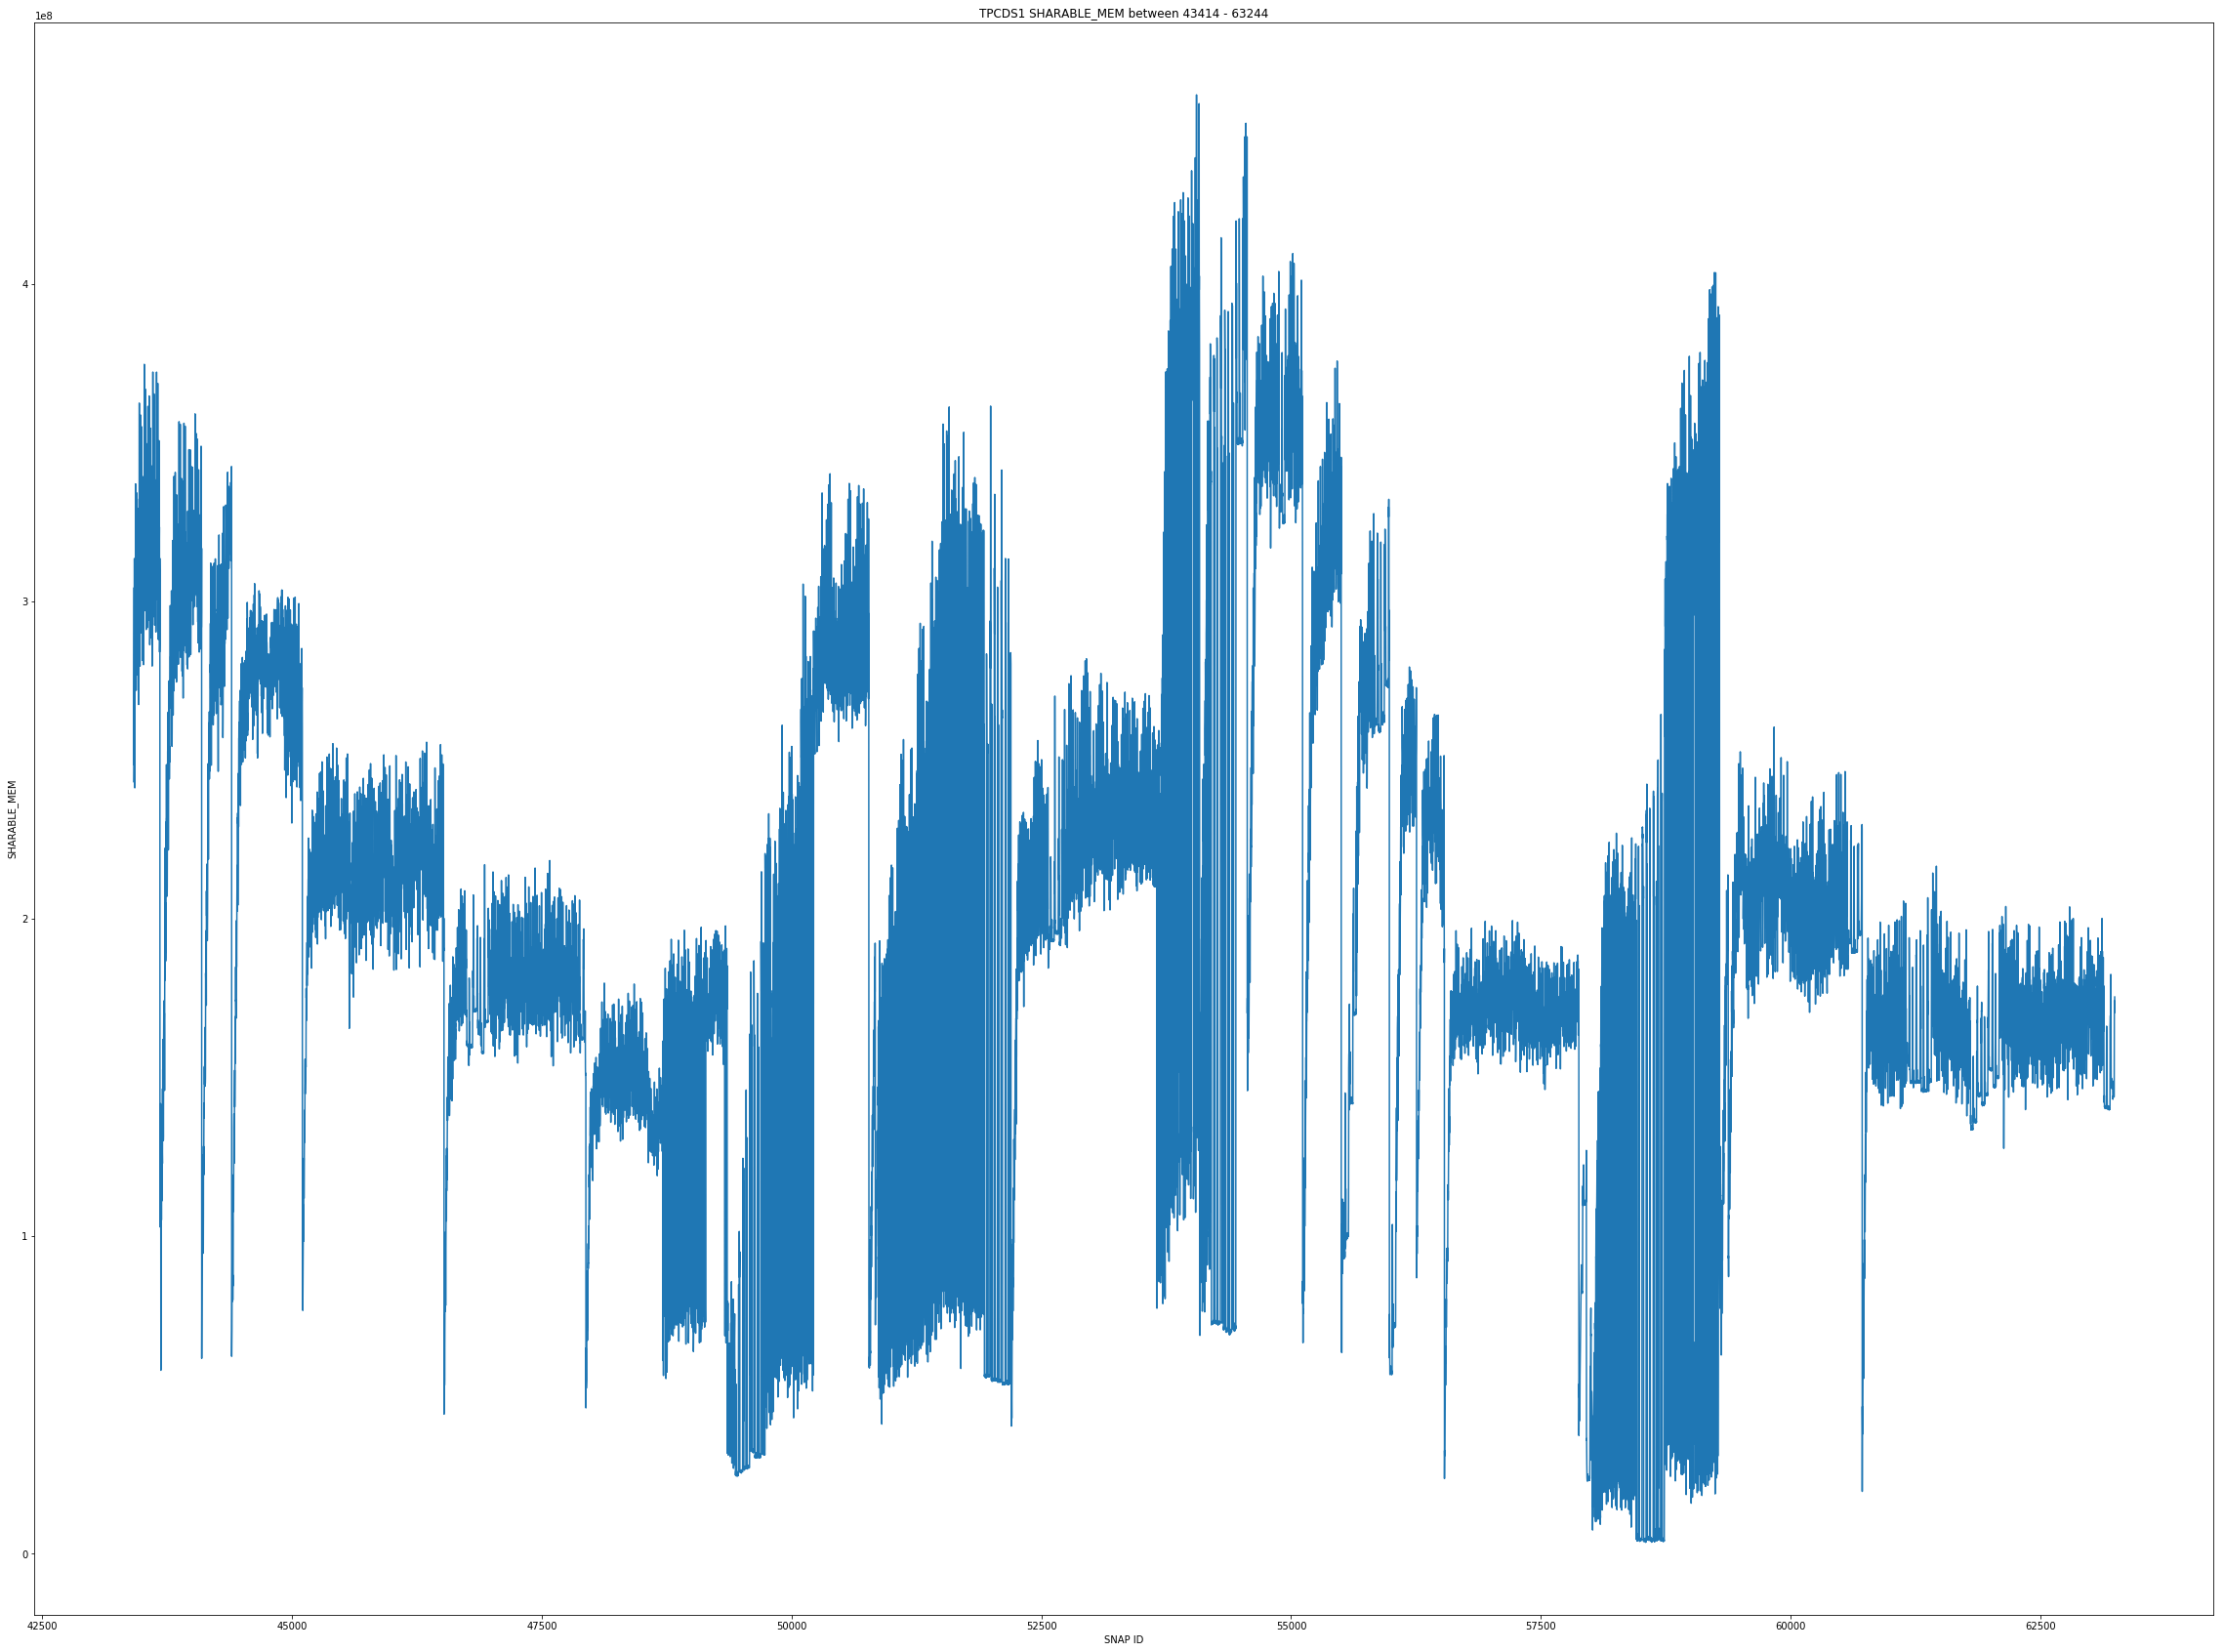

In [11]:
plot_snapshot_distribution(table="rep_hist_snapshot", column="SHARABLE_MEM", tpc_type=tpcds)

### Parsing Schema Name

Schema ID that was used to originally build the child cursor

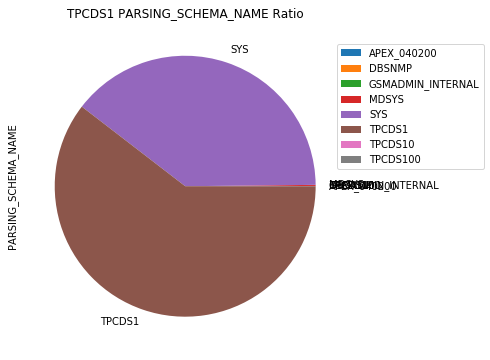

In [12]:
plot_snapshot_ratios(table="rep_hist_snapshot", column="PARSING_SCHEMA_NAME", tpc_type=tpcds)

### Fetches Delta

Summation of delta number of fetches associated with the SQL statement

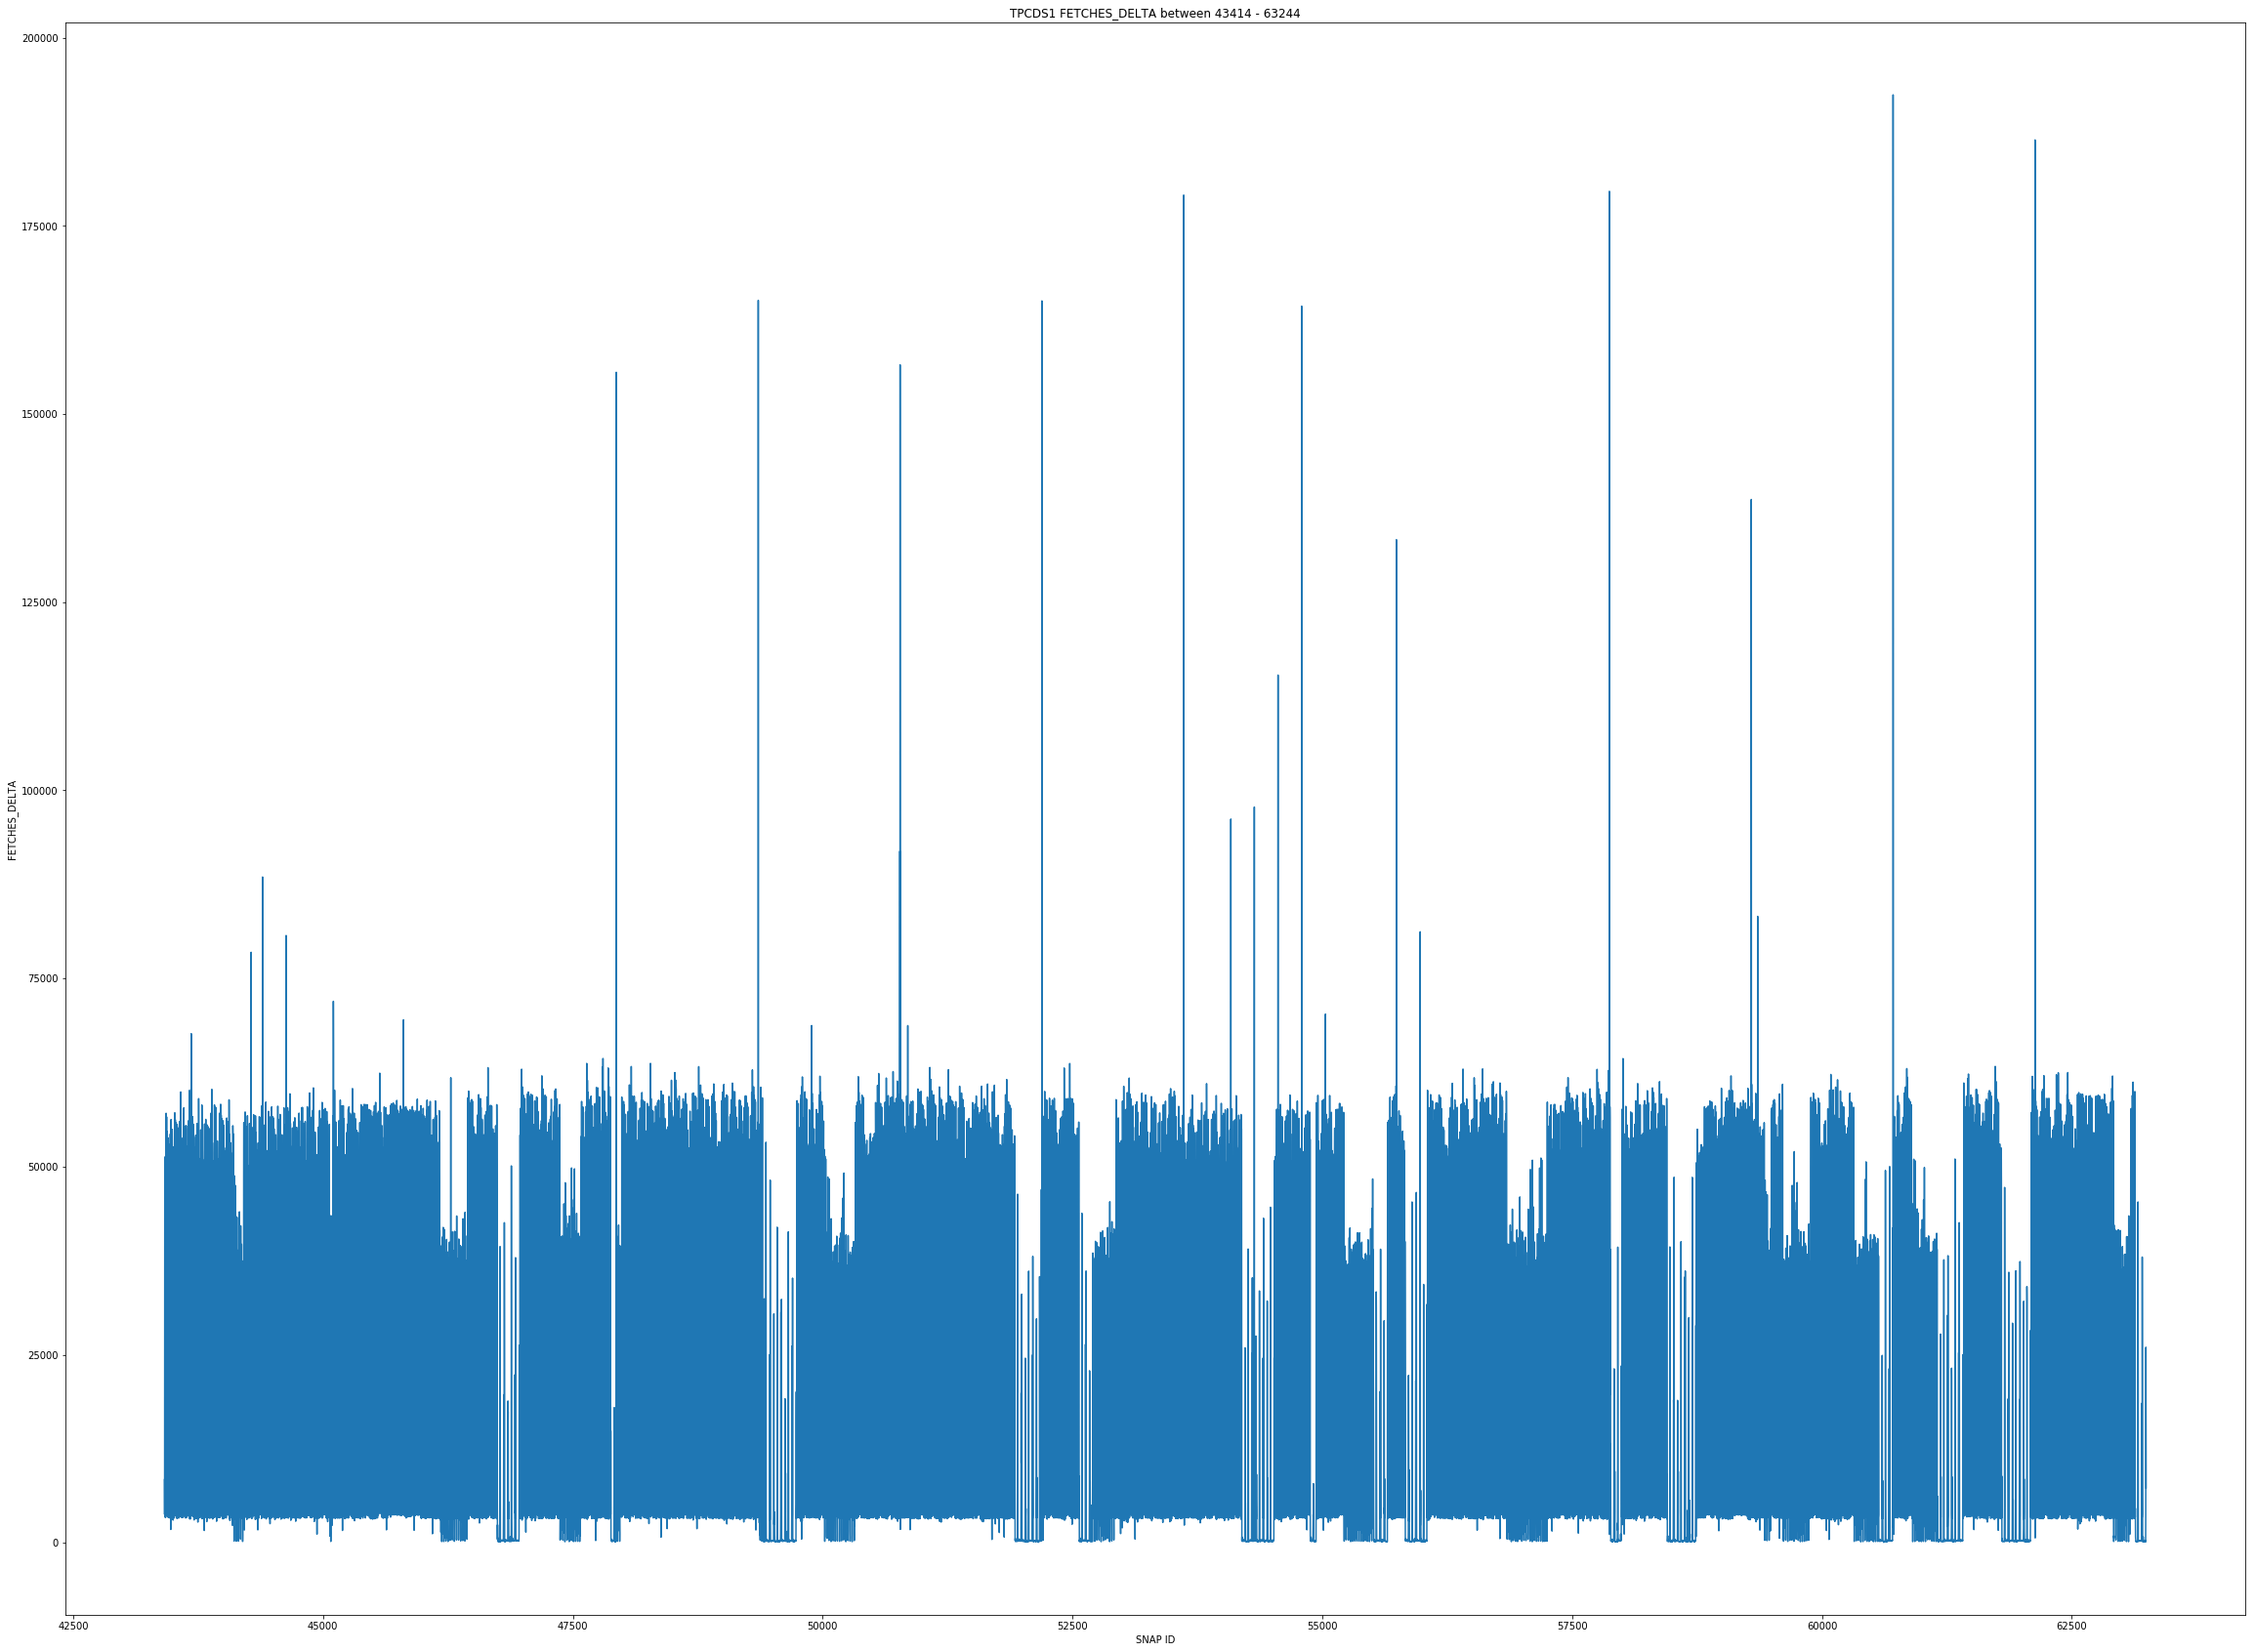

In [13]:
plot_snapshot_distribution(table="rep_hist_snapshot", column="FETCHES_DELTA", tpc_type=tpcds)

### End Of Fetch Count Delta

Delta number of times this cursor was fully executed since the cursor was brought into the library cache. The value of this statistic is not incremented when the cursor is partially executed, either because it failed during the execution or because only the first few rows produced by this cursor are fetched before the cursor is closed or re-executed.

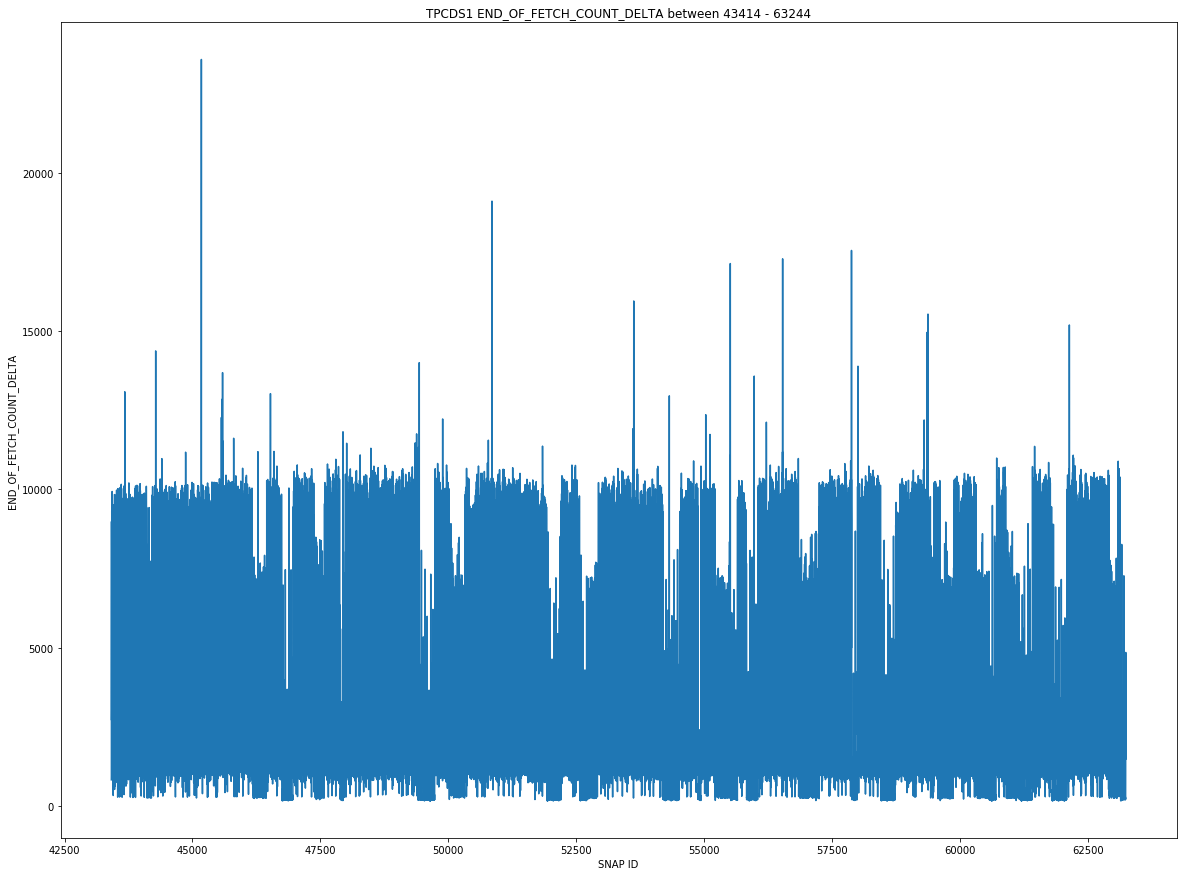

In [14]:
plot_snapshot_distribution(table="rep_hist_snapshot", column="END_OF_FETCH_COUNT_DELTA", tpc_type=tpcds)

### Sorts Delta

Delta number of sorts that were done for this child cursor

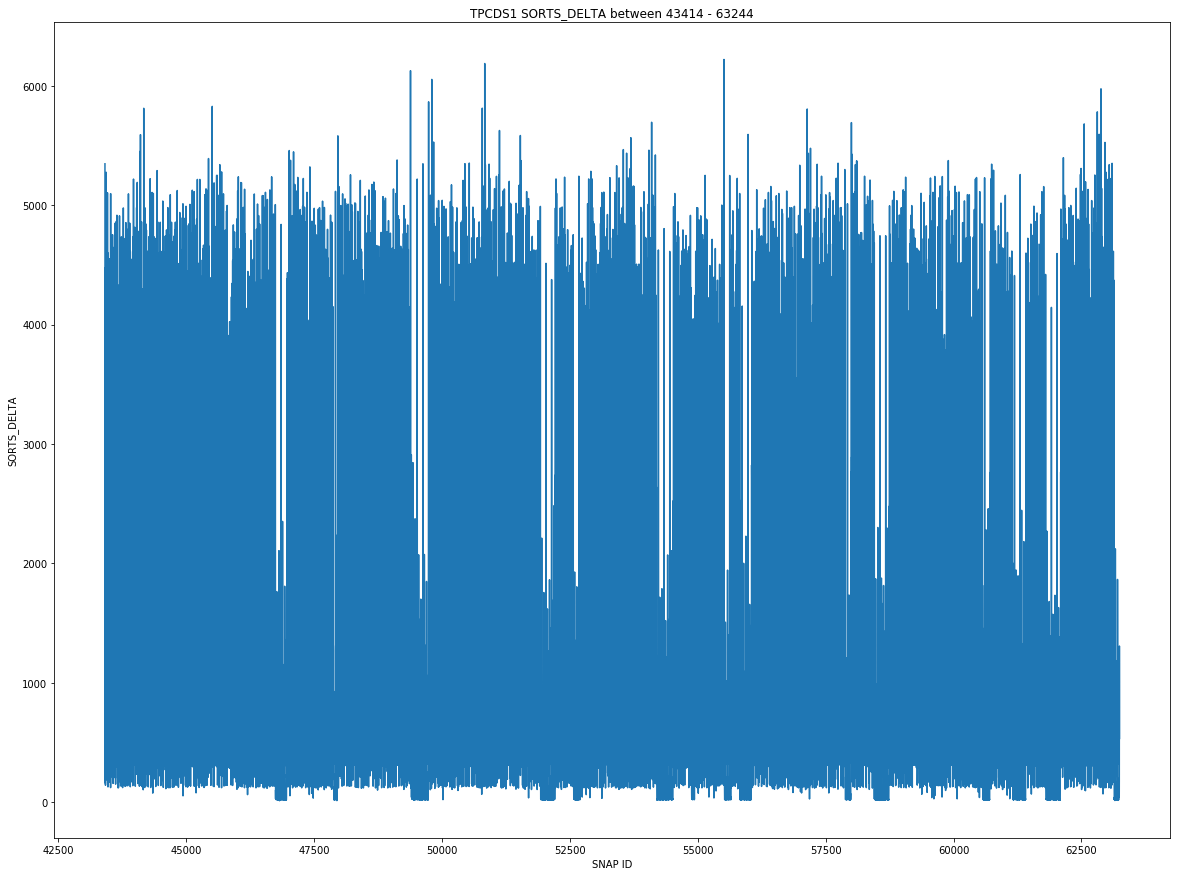

In [15]:
plot_snapshot_distribution(table="rep_hist_snapshot", column="SORTS_DELTA", tpc_type=tpcds)

### Executions Delta

Delta number of executions that took place on this object since it was brought into the library cache

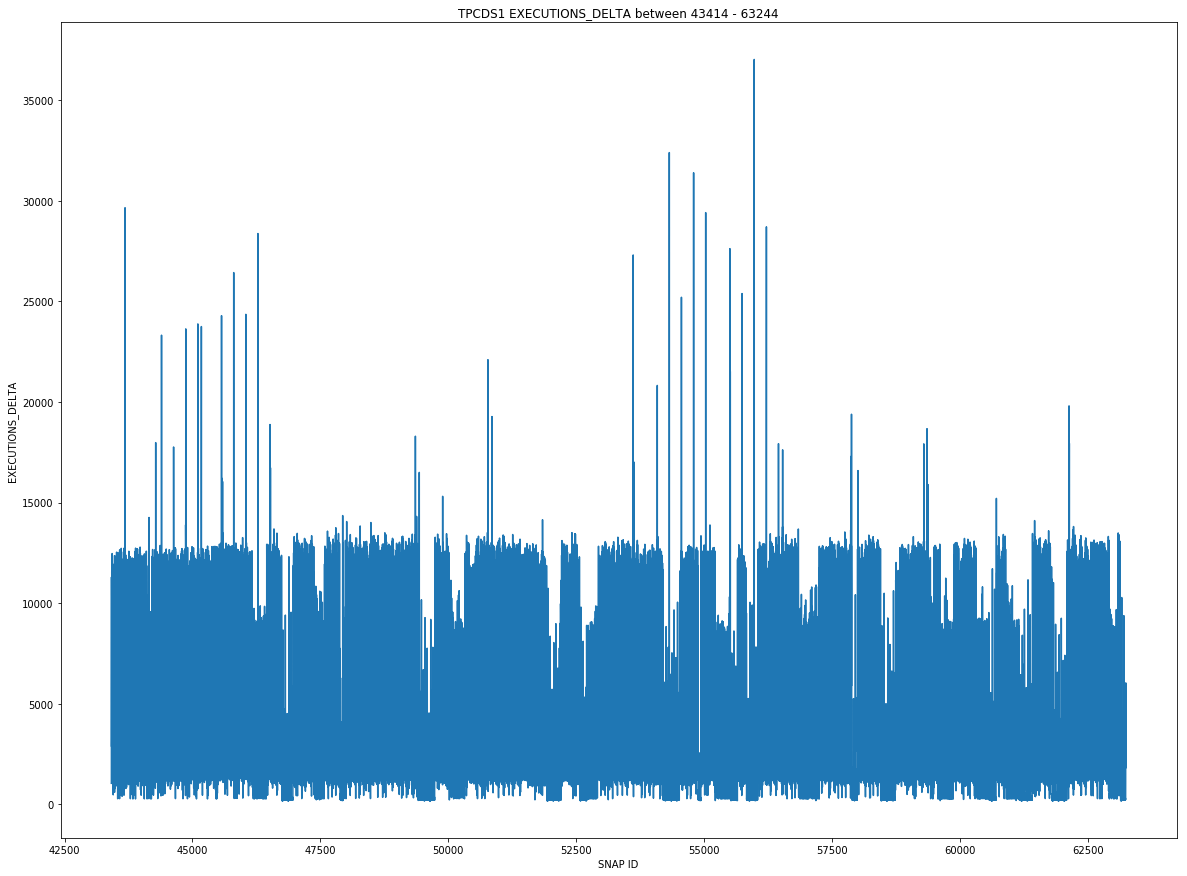

In [16]:
plot_snapshot_distribution(table="rep_hist_snapshot", column="EXECUTIONS_DELTA", tpc_type=tpcds)

### Loads Delta

Delta number of times the object was either loaded or reloaded

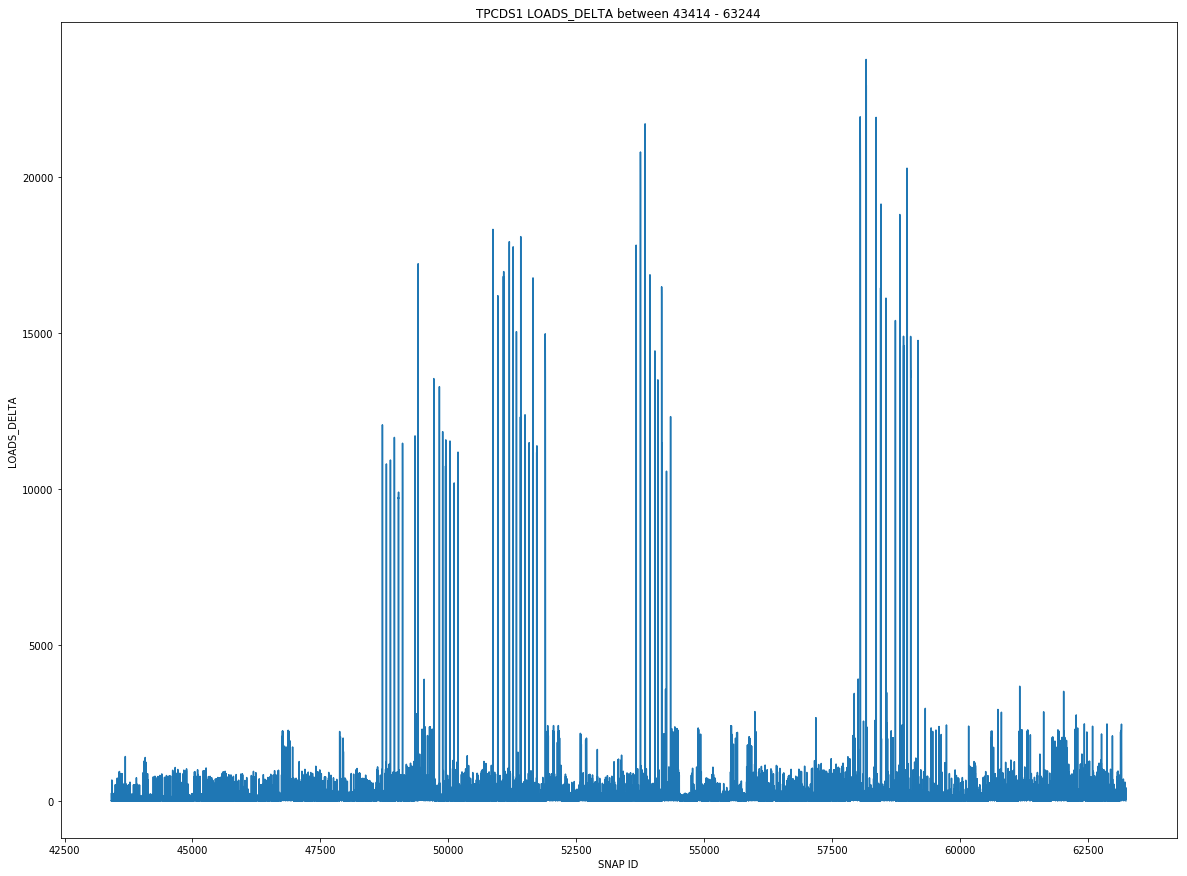

In [17]:
plot_snapshot_distribution(table="rep_hist_snapshot", column="LOADS_DELTA", tpc_type=tpcds)

### Invalidation Delta

Delta number of times this child cursor has been invalidated

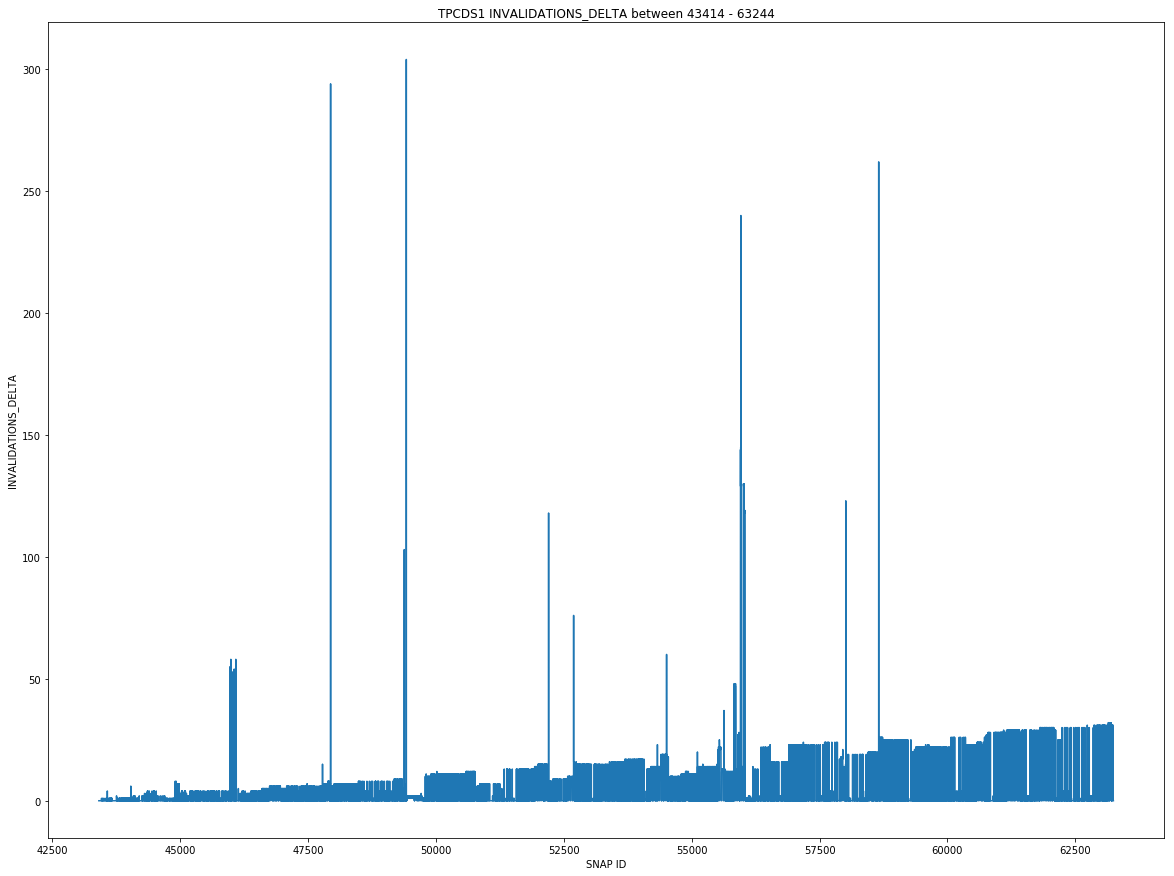

In [18]:
plot_snapshot_distribution(table="rep_hist_snapshot", column="INVALIDATIONS_DELTA", tpc_type=tpcds)

### Parse Calls Delta

Delta number of parse calls for this child cursor

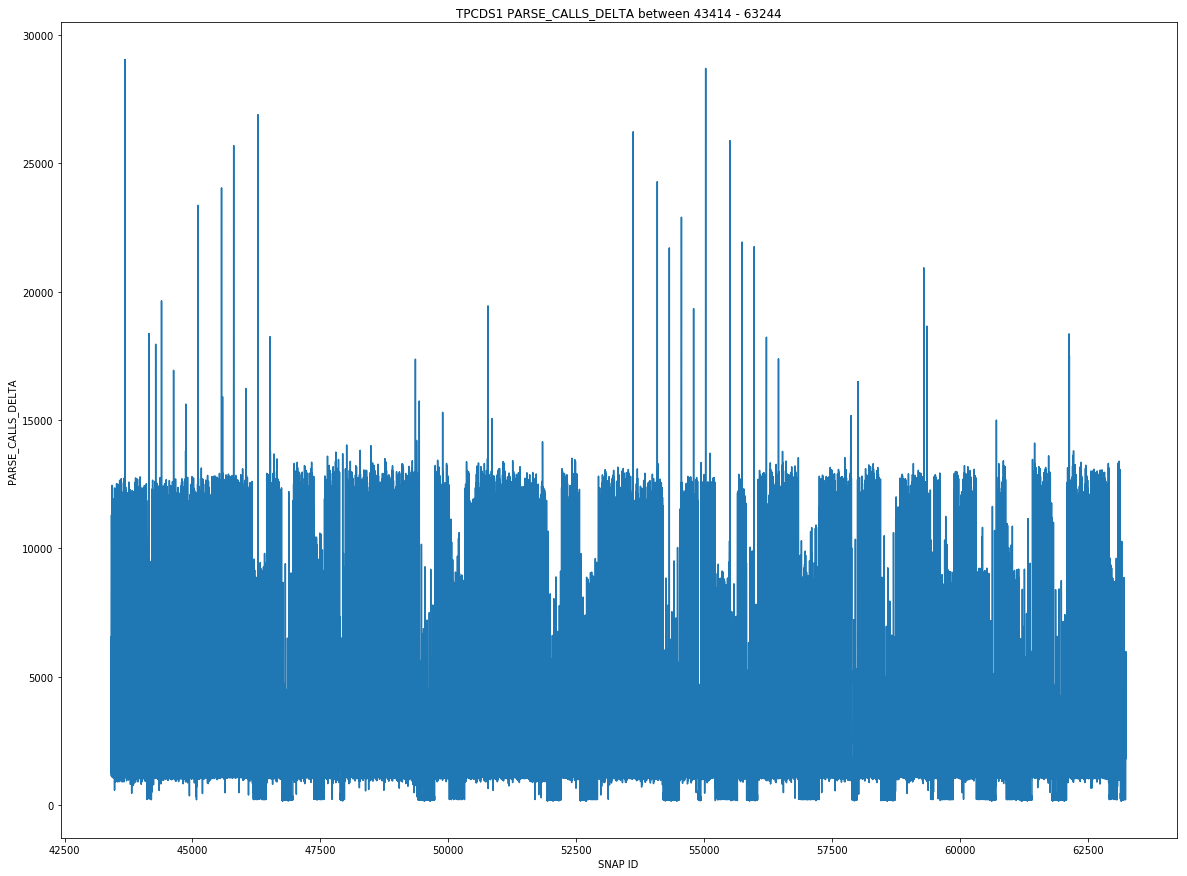

In [19]:
plot_snapshot_distribution(table="rep_hist_snapshot", column="PARSE_CALLS_DELTA", tpc_type=tpcds)

### Disk Reads Delta

Delta number of disk reads for this child cursor

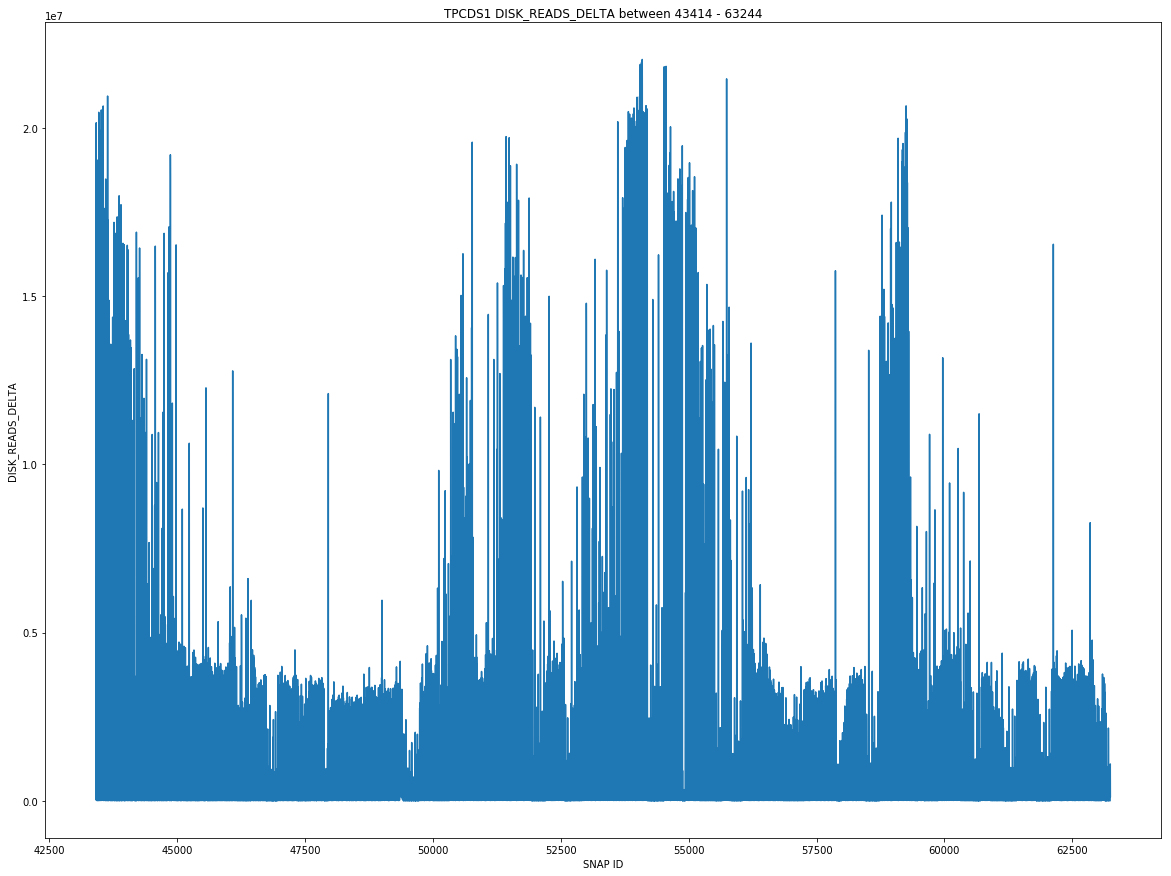

In [20]:
plot_snapshot_distribution(table="rep_hist_snapshot", column="DISK_READS_DELTA", tpc_type=tpcds)

### Buffer Gets Delta

Delta number of buffer gets for this child cursor

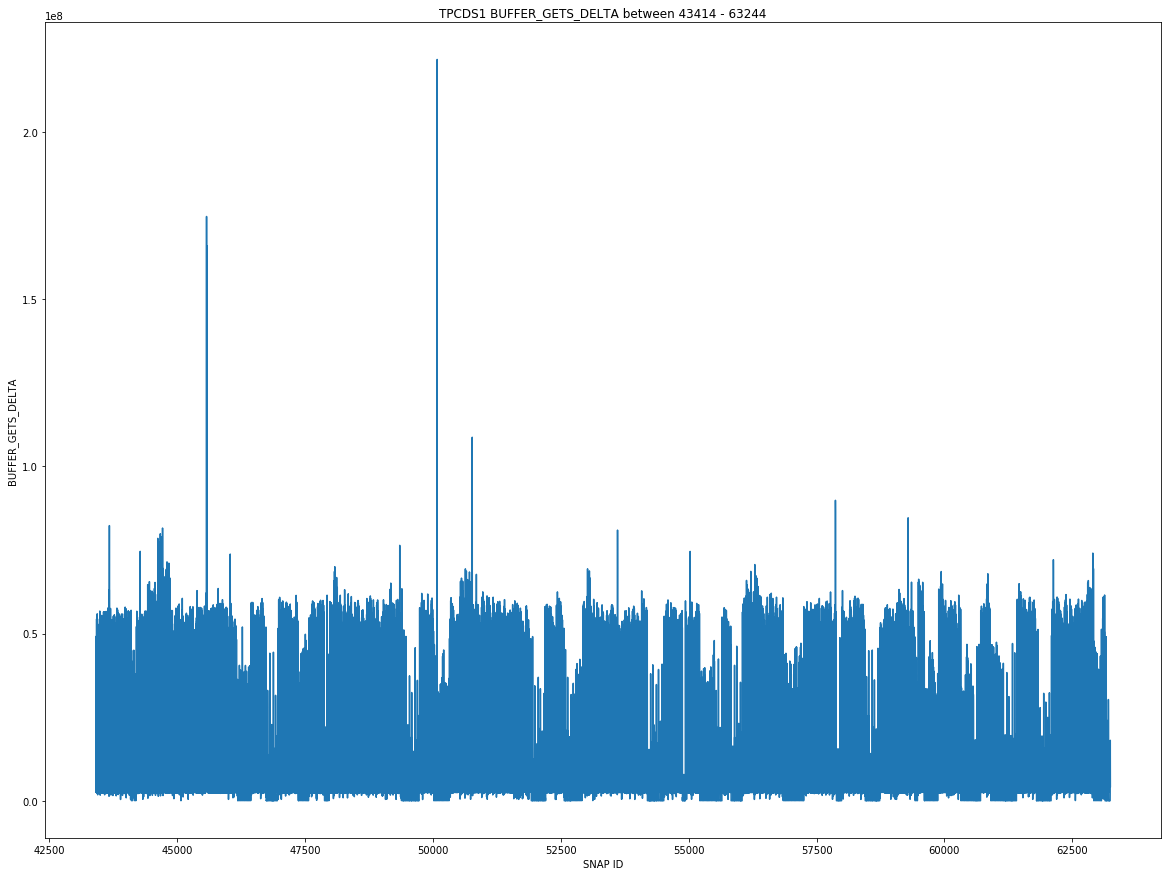

In [21]:
plot_snapshot_distribution(table="rep_hist_snapshot", column="BUFFER_GETS_DELTA", tpc_type=tpcds)

### Rows Processed Delta

Delta number of rows the parsed SQL statement returns

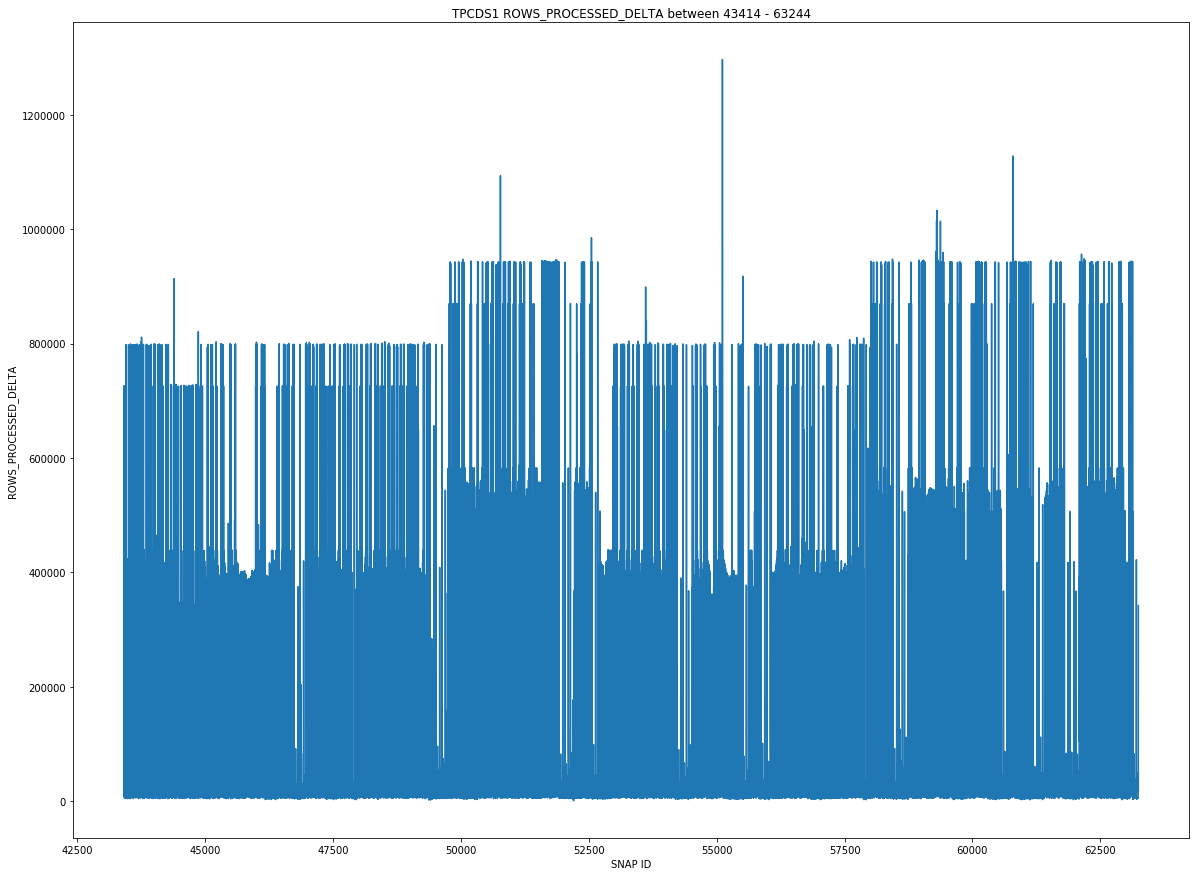

In [22]:
plot_snapshot_distribution(table="rep_hist_snapshot", column="ROWS_PROCESSED_DELTA", tpc_type=tpcds)

### CPU Time Delta

Delta value of CPU time (in microseconds) used by this cursor for parsing/executing/fetching

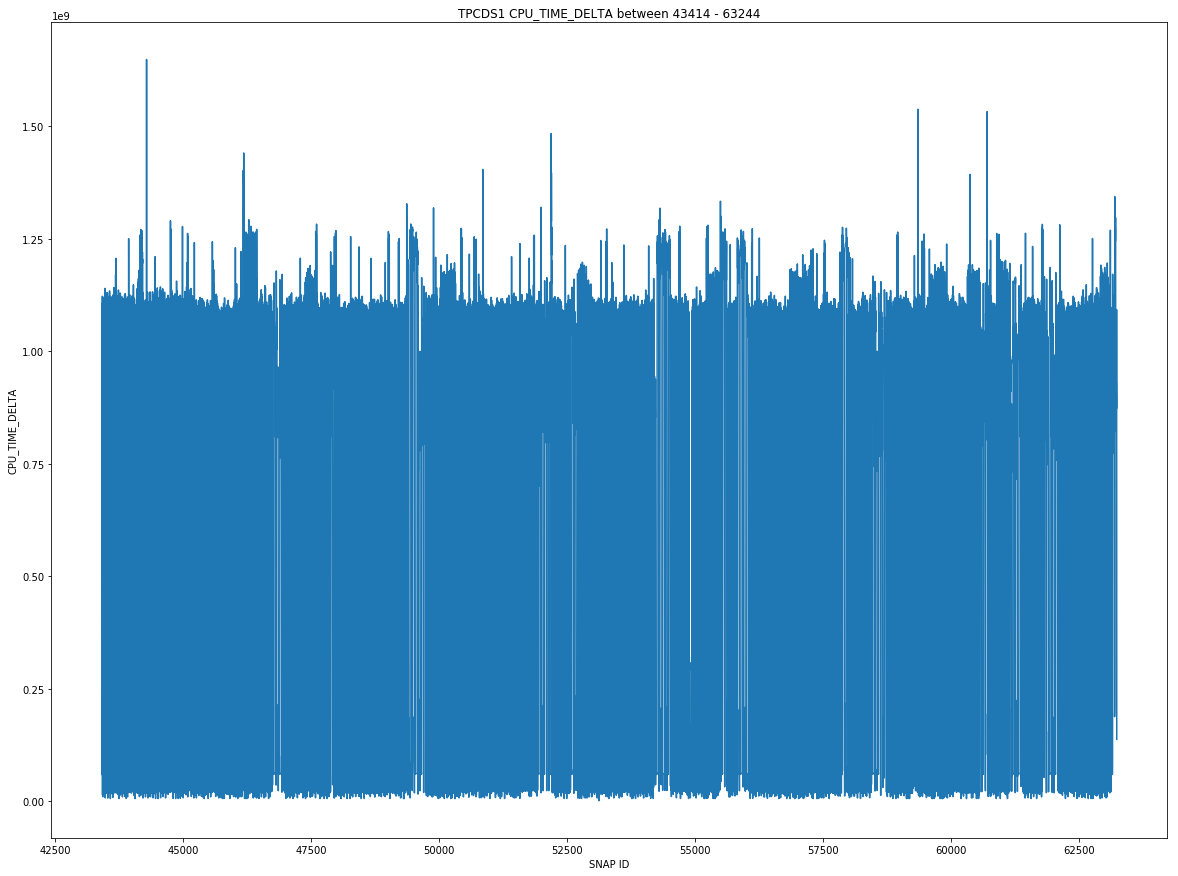

In [23]:
plot_snapshot_distribution(table="rep_hist_snapshot", column="CPU_TIME_DELTA", tpc_type=tpcds)

### Elapsed Time Delta

Delta value of elapsed time (in microseconds) used by this cursor for parsing/executing/fetching

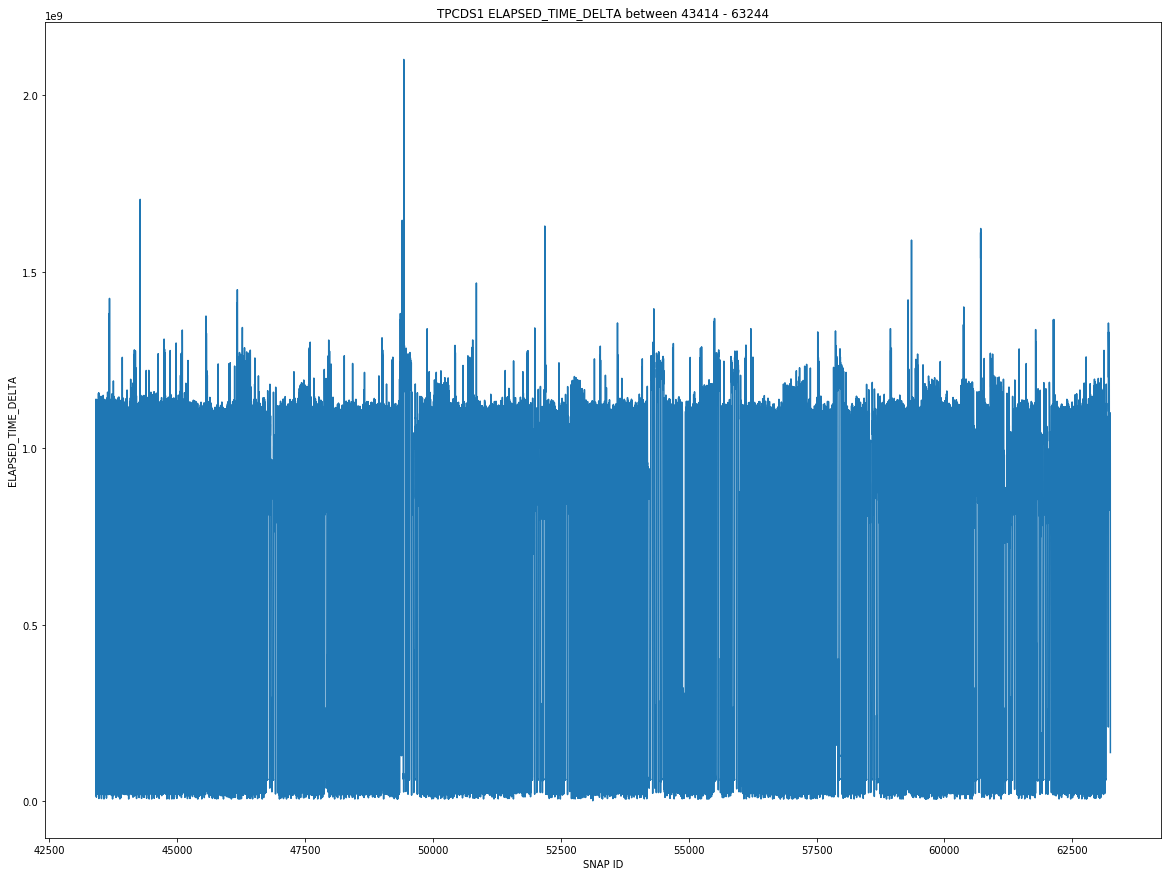

In [24]:
plot_snapshot_distribution(table="rep_hist_snapshot", column="ELAPSED_TIME_DELTA", tpc_type=tpcds)

### IO Wait Delta

Delta value of user I/O wait time

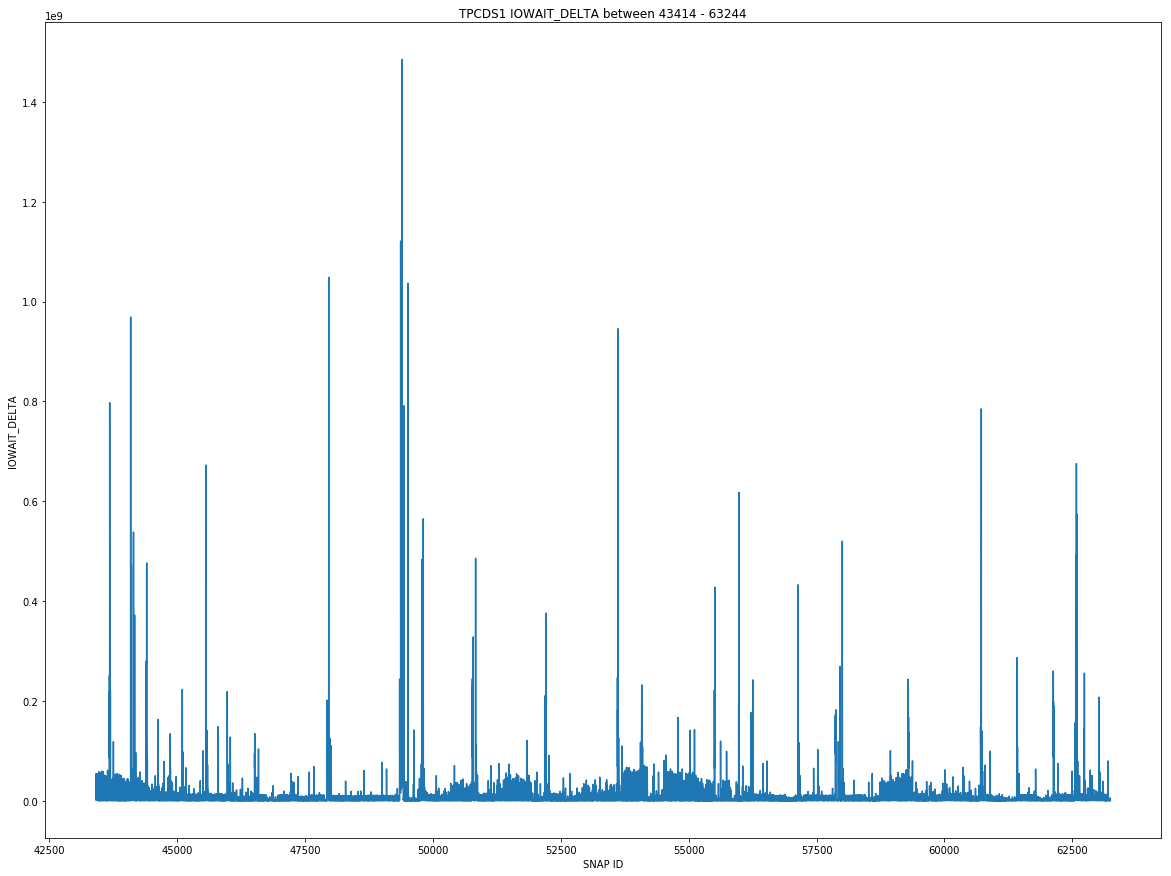

In [25]:
plot_snapshot_distribution(table="rep_hist_snapshot", column="IOWAIT_DELTA", tpc_type=tpcds)

### Cluster Wait Time

Delta value of cluster wait time

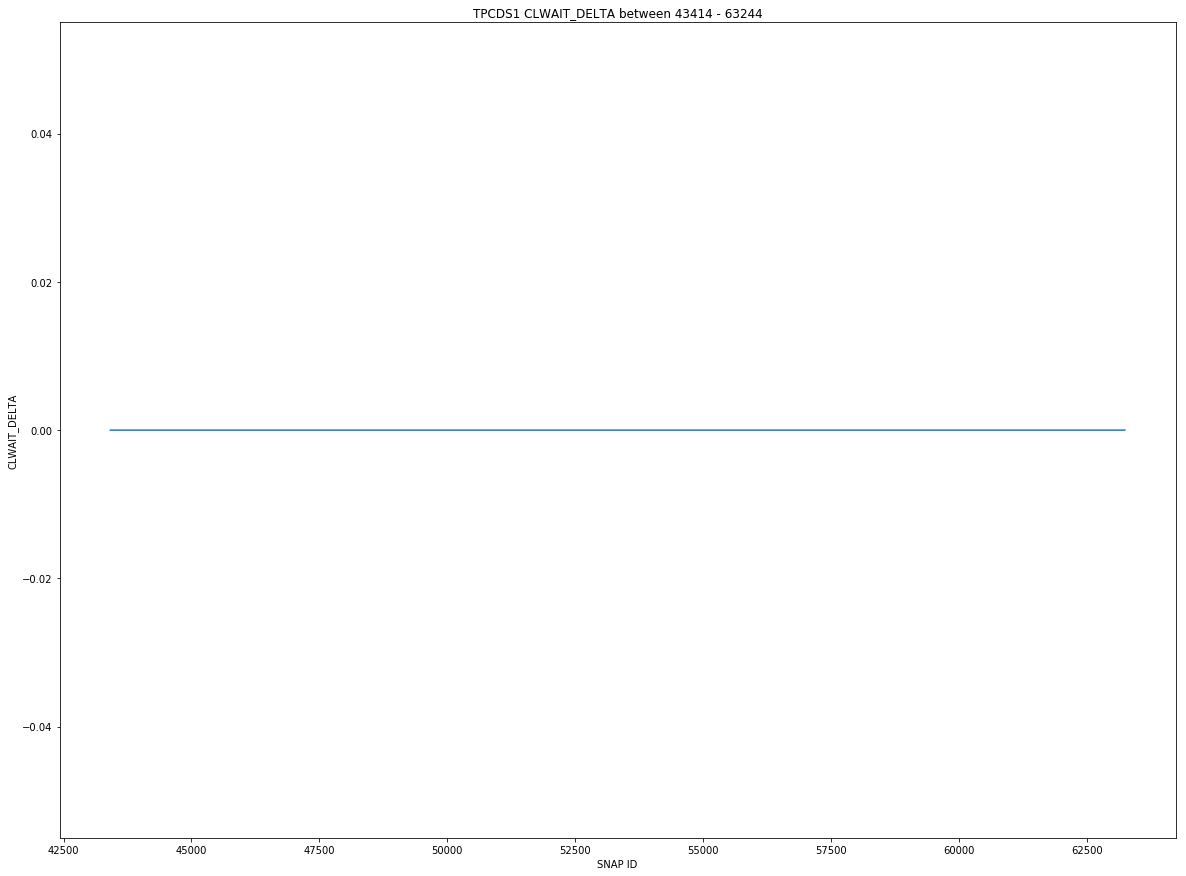

In [26]:
plot_snapshot_distribution(table="rep_hist_snapshot", column="CLWAIT_DELTA", tpc_type=tpcds)

### APWait Delta

Delta value of application wait time

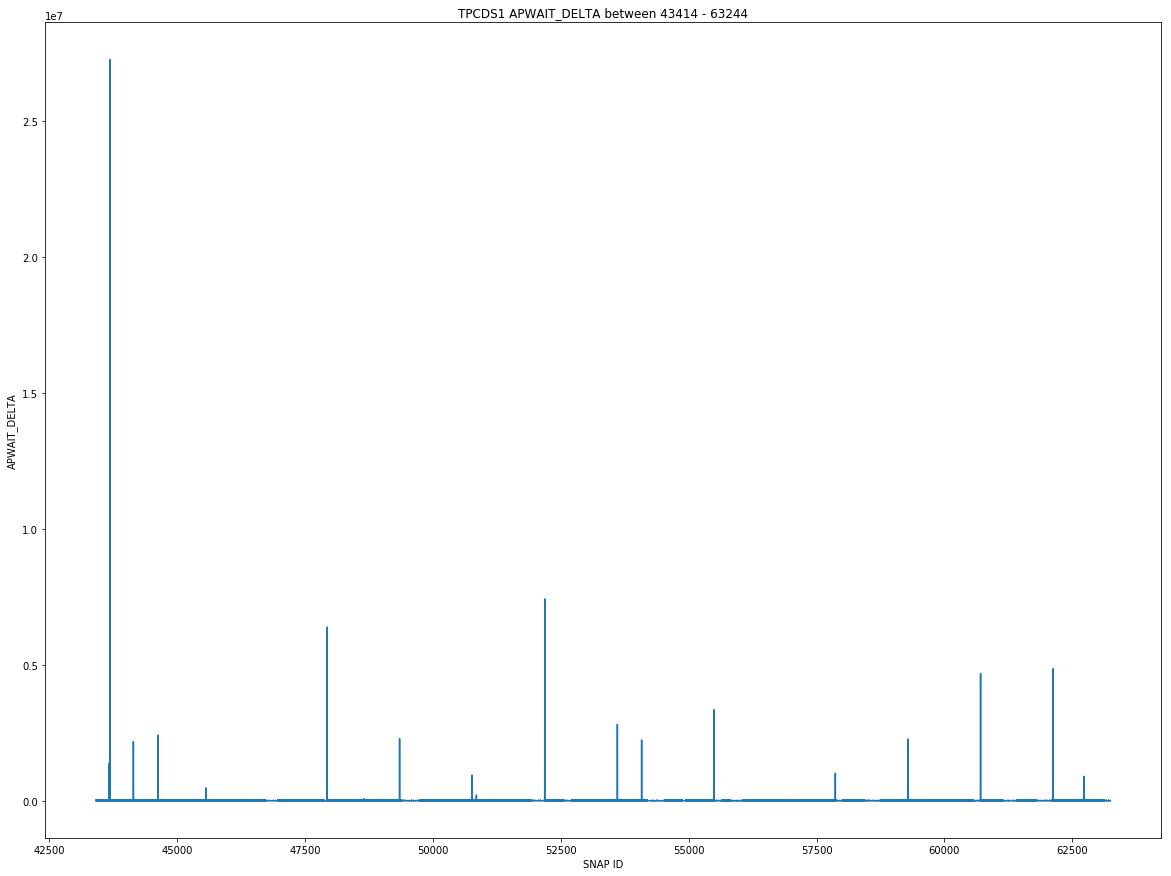

In [27]:
plot_snapshot_distribution(table="rep_hist_snapshot", column="APWAIT_DELTA", tpc_type=tpcds)

### CCWait Delta

Delta value of concurrency wait time

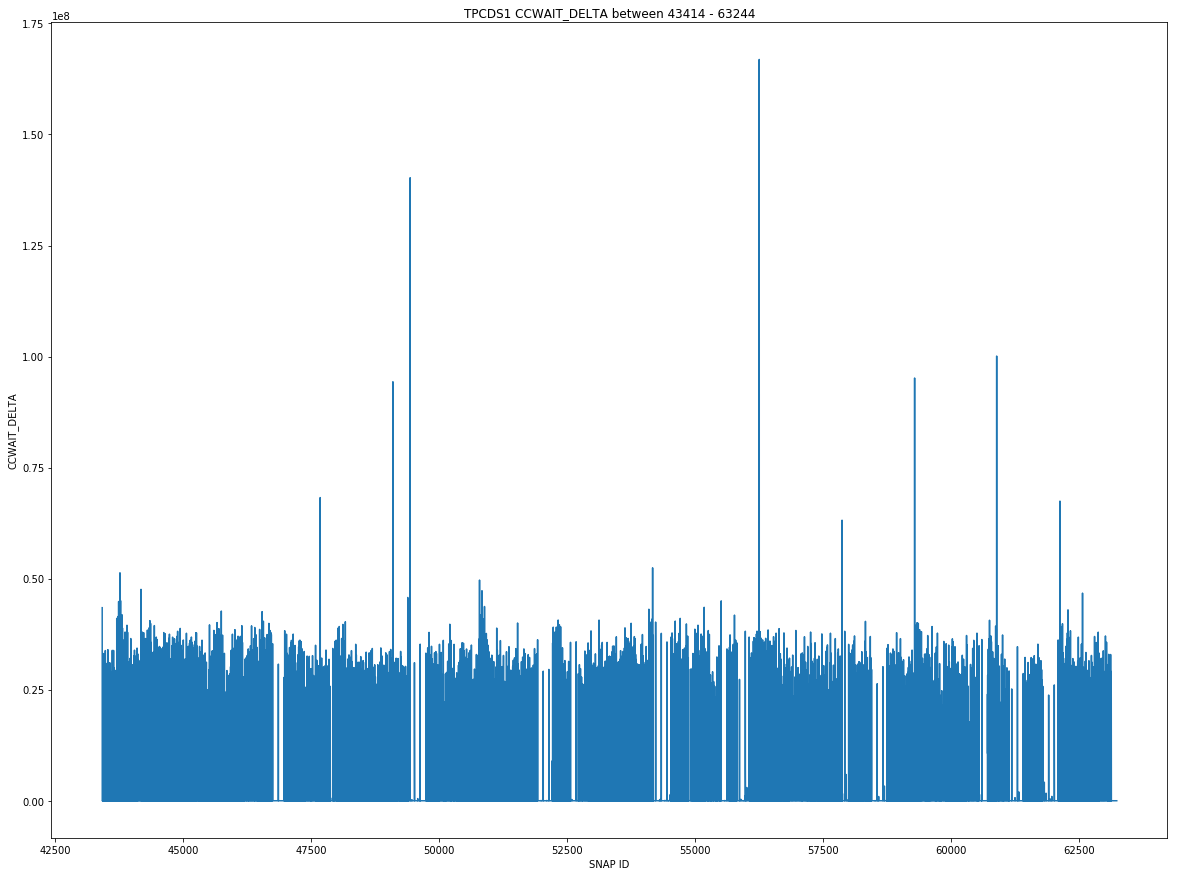

In [28]:
plot_snapshot_distribution(table="rep_hist_snapshot", column="CCWAIT_DELTA", tpc_type=tpcds)

### Direct Writes Delta

Delta value of direct writes

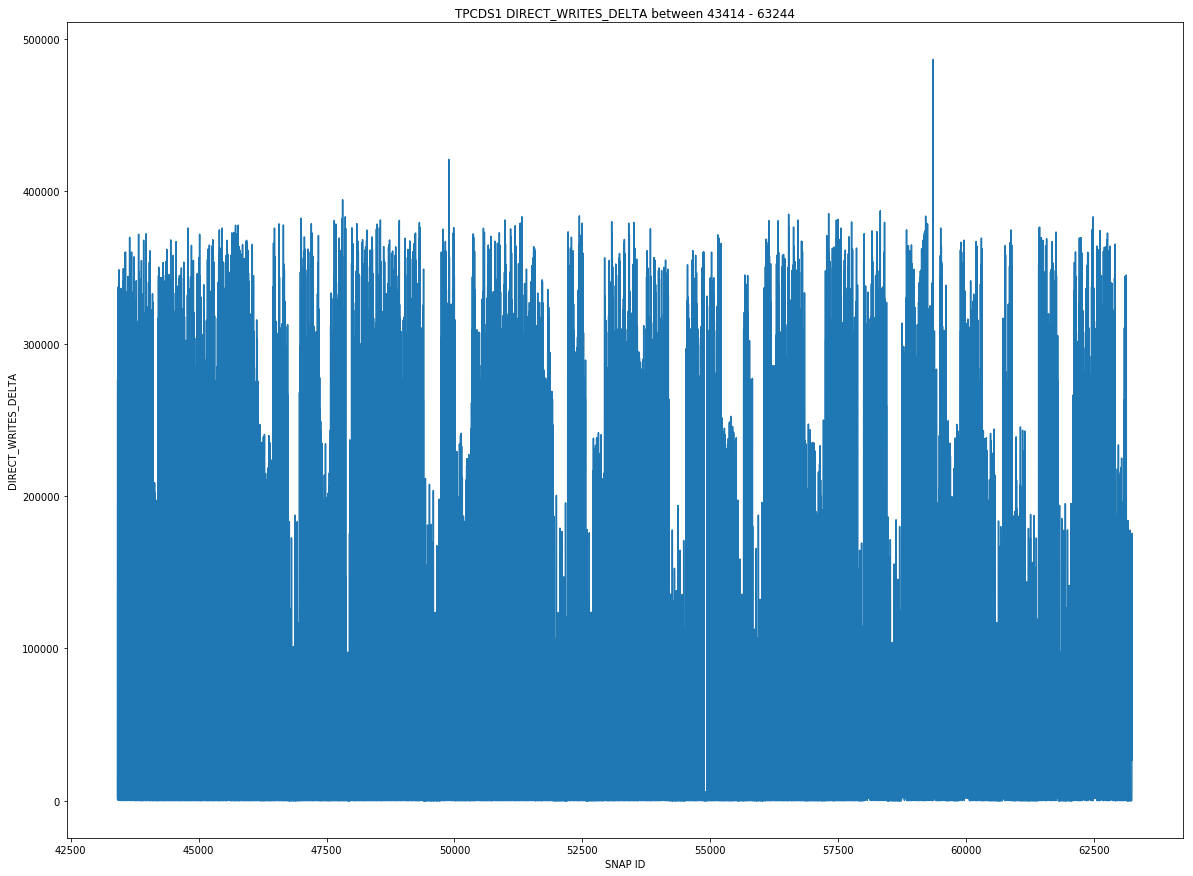

In [29]:
plot_snapshot_distribution(table="rep_hist_snapshot", column="DIRECT_WRITES_DELTA", tpc_type=tpcds)

### PLSExec Time Delta

Delta value of PL/SQL Execution Time

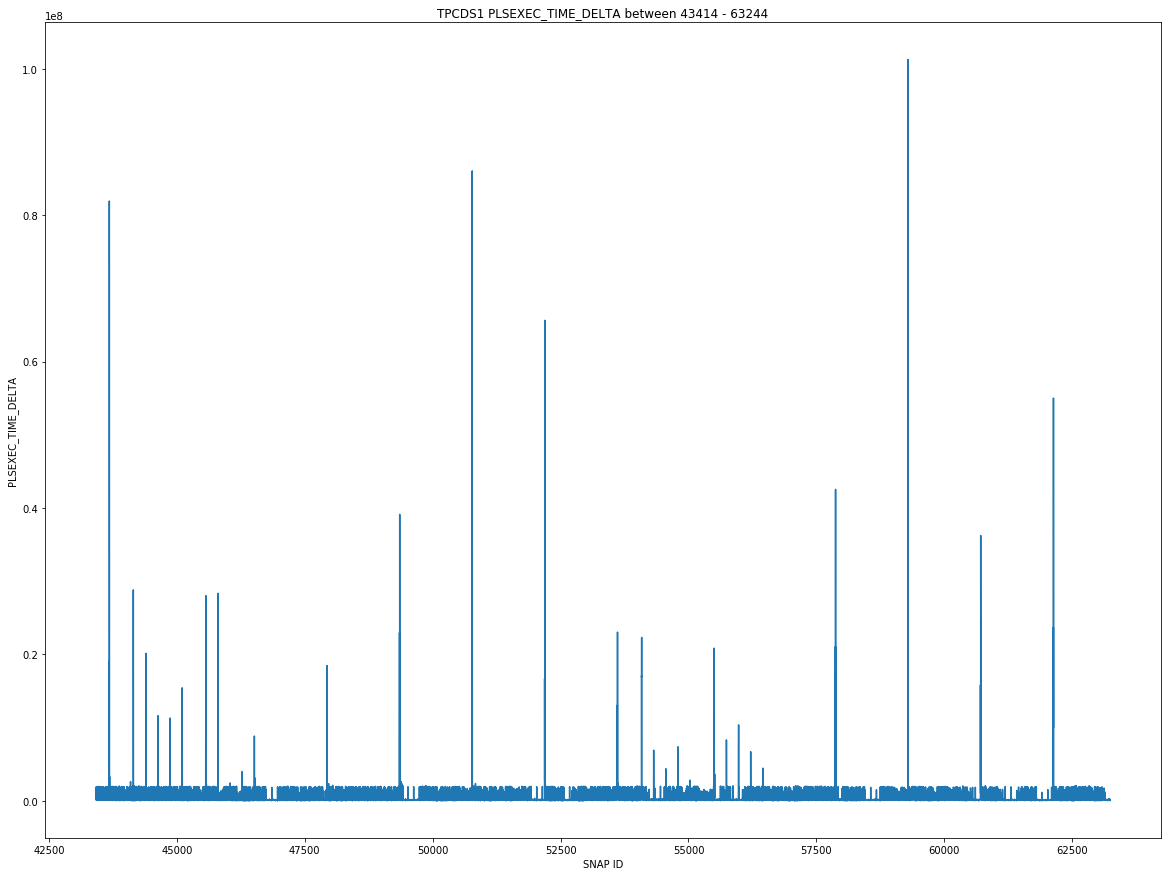

In [30]:
plot_snapshot_distribution(table="rep_hist_snapshot", column="PLSEXEC_TIME_DELTA", tpc_type=tpcds)

### JavaExec Time Delta

Delta value of Java Execution Time

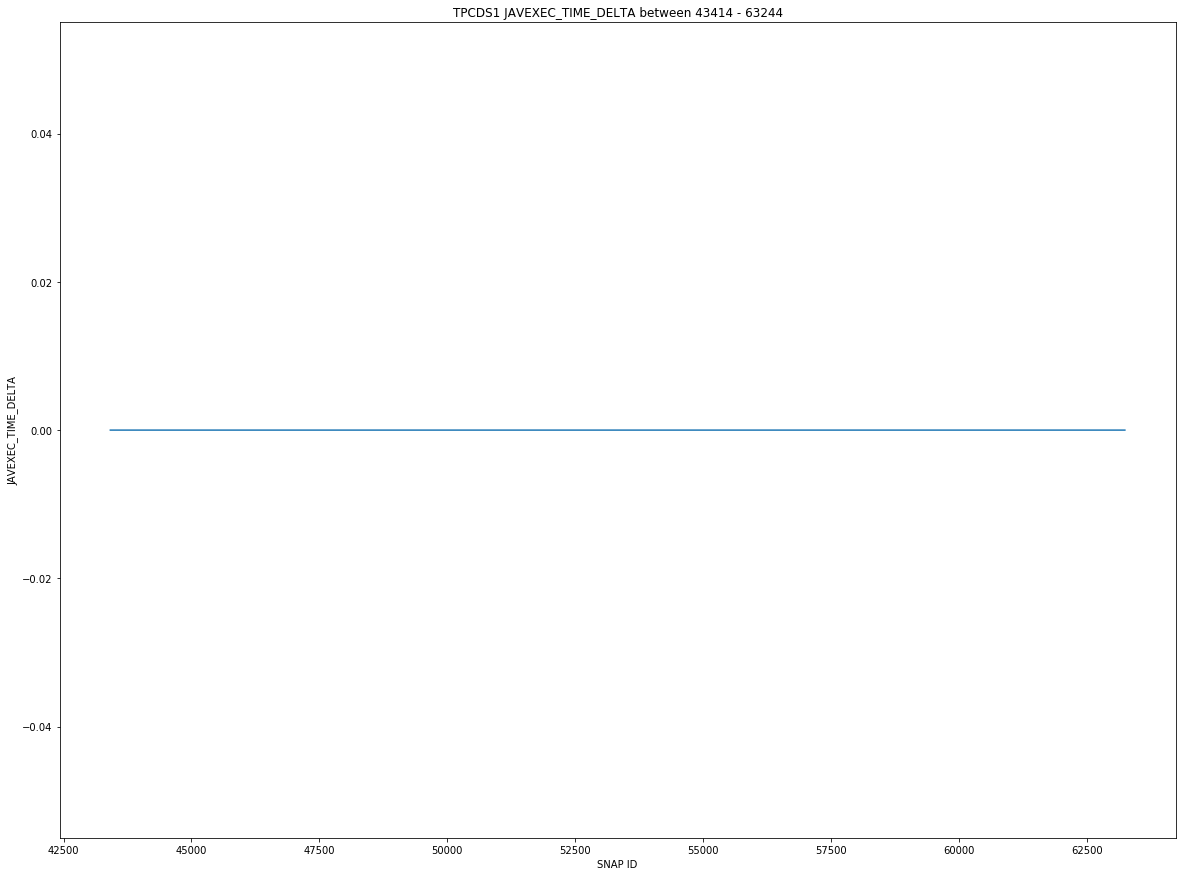

In [31]:
plot_snapshot_distribution(table="rep_hist_snapshot", column="JAVEXEC_TIME_DELTA", tpc_type=tpcds)